# Relationship Between Age and DNA Methylation: Multiple Solutions

## Problem Statement

We are given two data files:

- **MethylDataWithDbgapId.txt:** A table where each row is a CpG and each column corresponds to an individual (identified by a dbGaP ID), with the entries representing methylation values.
- **subjects.txt:** A table containing subject information (Age, sex, Race) where the dbGaP IDs match those in the methylation file.

The main questions are:

1. What is the relationship between age and methylation?
2. Which strategies can be used to test this relationship?
   - **Univariate correlation analysis:** Compute Pearson and Spearman correlations between each CpG and age (using packages like `scipy`, `pandas`).
   - **Penalized regression (e.g., LASSO):** Build an epigenetic clock to predict age and select important CpGs (using scikit‑learn).
   - **Machine learning methods:** Use non‐linear approaches like Random Forests to model the age–methylation relationship (scikit‑learn).

3. Is methylation predictive of age? And are all CpGs associated with age or only a subset?

This notebook explores multiple strategies to address these questions.

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

sns.set(style="whitegrid")

# For reproducibility
np.random.seed(42)

## Data Preparation

Load the methylation and subject data, ensure the dbGaP IDs match, and extract the age information.

In [6]:
# Read the data files (tab-delimited)
meth_df = pd.read_csv("../files/data/methylation/metRmOlWithDbgapId.txt", sep="\t", index_col=0)
subjects_df = pd.read_csv("../files/data/methylation/subjects.txt", sep="\t")

# Convert methylation data columns to string (they represent dbGaP IDs)
meth_df.columns = meth_df.columns.astype(str)

# Ensure subject IDs are strings
subjects_df["dbGaP ID"] = subjects_df["dbGaP ID"].astype(str)
individual_ids = subjects_df["dbGaP ID"].tolist()

# Reorder methylation data columns to match subject IDs
meth_df = meth_df[individual_ids]

# Create an age Series indexed by dbGaP ID
age_series = subjects_df.set_index("dbGaP ID")["Age"]

# Display head of dataframes for confirmation
print(meth_df.head())
print(subjects_df.head())

                     34        35        37        39        40        41  \
dbGapSubjctId                                                               
cg26211698     0.018852  0.023741  0.023376  0.037224  0.018712  0.025110   
cg03790787     0.068036  0.081941  0.103914  0.051119  0.104110  0.088810   
cg04672450     0.009639  0.013243  0.010931  0.022289  0.012151  0.013536   
cg14324200     0.204592  0.064252  0.133139  0.059606  0.092799  0.113580   
cg04485075     0.010062  0.015012  0.012881  0.047412  0.017496  0.022166   

                     44        46        52        53  ...        14  \
dbGapSubjctId                                          ...             
cg26211698     0.015484  0.021162  0.020475  0.026372  ...  0.022684   
cg03790787     0.081404  0.076911  0.062057  0.081126  ...  0.057089   
cg04672450     0.016800  0.013280  0.013590  0.007595  ...  0.009227   
cg14324200     0.094694  0.166240  0.158260  0.175960  ...  0.108734   
cg04485075     0.014335  0.0

## Strategy 1: Univariate Correlation Analysis

### A. Pearson Correlation

For each CpG, we compute the Pearson correlation with age. This provides a linear measure of association.

Top 10 CpGs (Pearson correlation, absolute values):
dbGapSubjctId
cg22736354    0.940735
cg17050972    0.936079
cg15201877    0.935615
cg21053323    0.929218
cg06156376    0.924342
cg00548268    0.923855
cg05266781    0.918156
cg06462291    0.913865
cg02409351    0.909649
cg27529628    0.907694
dtype: float64


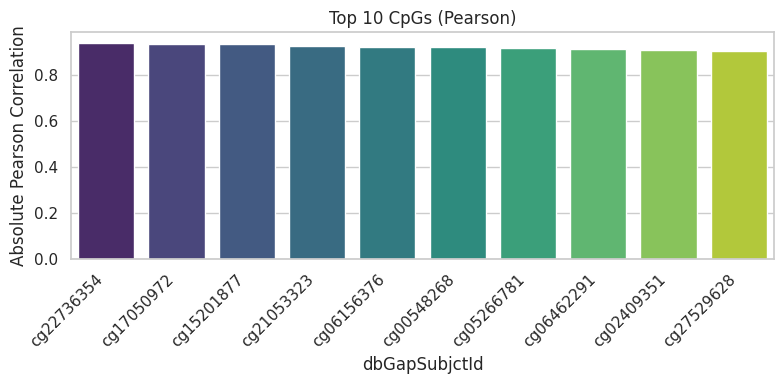

In [12]:
# Compute Pearson correlation for each CpG
def pearson_corr(row):
    corr, _ = pearsonr(row, age_series)
    return corr

pearson_corrs = meth_df.apply(pearson_corr, axis=1)

# Display top 10 CpGs by absolute Pearson correlation
top_pearson = pearson_corrs.abs().sort_values(ascending=False).head(10)
print("Top 10 CpGs (Pearson correlation, absolute values):")
print(top_pearson)

# Bar plot
plt.figure(figsize=(8,4))
sns.barplot(x=top_pearson.index, y=top_pearson.values, palette="viridis", hue=top_pearson.index)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Absolute Pearson Correlation")
plt.title("Top 10 CpGs (Pearson)")
plt.tight_layout()
plt.show()

### B. Spearman Correlation

We also compute the Spearman rank correlation to capture non-linear monotonic relationships.

Top 10 CpGs (Spearman correlation, absolute values):
dbGapSubjctId
cg00548268    0.937719
cg21053323    0.934072
cg22736354    0.932236
cg17050972    0.931898
cg06144905    0.929642
cg06156376    0.924889
cg16076328    0.920955
cg15201877    0.920087
cg17655614    0.915305
cg27301343    0.913846
dtype: float64


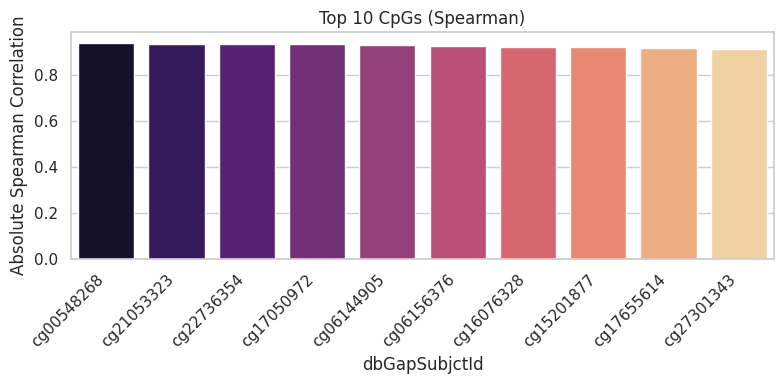

In [13]:
# Compute Spearman correlation for each CpG
def spearman_corr(row):
    corr, _ = spearmanr(row, age_series)
    return corr

spearman_corrs = meth_df.apply(spearman_corr, axis=1)

# Display top 10 CpGs by absolute Spearman correlation
top_spearman = spearman_corrs.abs().sort_values(ascending=False).head(10)
print("Top 10 CpGs (Spearman correlation, absolute values):")
print(top_spearman)

# Bar plot
plt.figure(figsize=(8,4))
sns.barplot(x=top_spearman.index, y=top_spearman.values, palette="magma", hue=top_spearman.index)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Absolute Spearman Correlation")
plt.title("Top 10 CpGs (Spearman)")
plt.tight_layout()
plt.show()

## Strategy 2: Predictive Modeling with LASSO Regression

We now build a linear model with LASSO regularization to predict age from methylation profiles. LASSO performs feature selection by shrinking less important coefficients to zero.

LASSO Regression R² score on training data: 0.9767935792460682

CpGs with nonzero coefficients from LASSO:
dbGapSubjctId
cg22736354    47.979243
cg21053323    40.909736
cg25462291    35.152919
cg02512860   -30.901207
cg06144905    30.541925
cg03562120   -25.364633
cg12876594   -18.947896
cg25771195     8.415090
cg12447832     8.126941
cg06458239     7.578557
cg00407150    -7.151567
cg24330042     6.995547
cg21992250     6.654488
cg06832950    -6.171340
cg23719124     5.508938
cg18564727     4.301222
cg23855989     3.911304
cg16547529     3.486779
cg01889448     3.136441
cg02595219     3.012395
cg12078929     2.999661
cg26927807    -2.753665
cg24993443     2.294958
cg06220755    -2.254863
cg24794433    -1.950475
cg03606258     1.939590
cg02171545    -1.865351
cg14129786    -1.719937
cg23183296     1.695537
cg16076328     1.671641
cg05740244     1.563600
cg09893305     1.281716
cg25569462     0.952314
cg22051636    -0.935019
cg22022041    -0.918173
cg01870826     0.870005
cg12437481    -

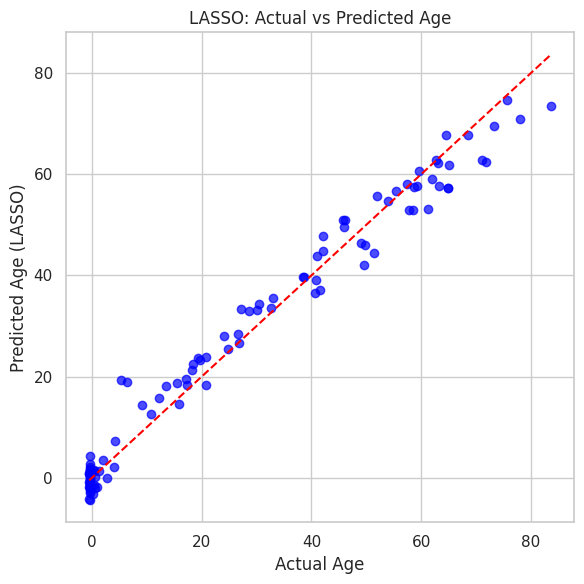

In [9]:
# Transpose methylation data: rows = individuals, columns = CpGs
X = meth_df.T
y = age_series.loc[X.index].values

# Fit LASSO regression with cross-validation
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000).fit(X, y)
y_pred_lasso = lasso_cv.predict(X)
r2_lasso = r2_score(y, y_pred_lasso)
print("LASSO Regression R² score on training data:", r2_lasso)

# Extract nonzero coefficients
coef_series = pd.Series(lasso_cv.coef_, index=meth_df.index)
important_cpgs_lasso = coef_series[coef_series != 0].sort_values(key=abs, ascending=False)
print("\nCpGs with nonzero coefficients from LASSO:")
print(important_cpgs_lasso)

# Plot actual vs predicted age for LASSO
plt.figure(figsize=(6,6))
plt.scatter(y, y_pred_lasso, color="blue", alpha=0.7)
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age (LASSO)")
plt.title("LASSO: Actual vs Predicted Age")
plt.plot([min(y), max(y)], [min(y), max(y)], color="red", linestyle="--")
plt.tight_layout()
plt.show()

## Strategy 3: Predictive Modeling with Random Forest Regression

Random Forests are non-linear ensemble methods that can capture complex relationships. Here we build a Random Forest model to predict age and compare its performance.

Random Forest Regression R² score on training data: 0.9889562467679027


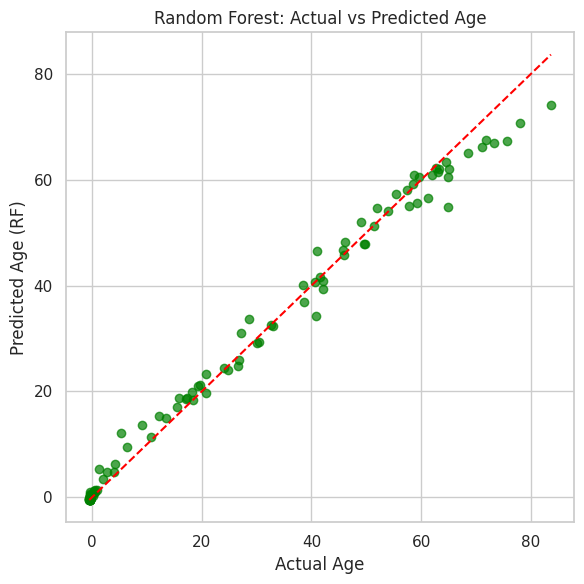

In [10]:
# Initialize and fit Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
y_pred_rf = rf.predict(X)
r2_rf = r2_score(y, y_pred_rf)
print("Random Forest Regression R² score on training data:", r2_rf)

# Plot actual vs predicted age for Random Forest
plt.figure(figsize=(6,6))
plt.scatter(y, y_pred_rf, color="green", alpha=0.7)
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age (RF)")
plt.title("Random Forest: Actual vs Predicted Age")
plt.plot([min(y), max(y)], [min(y), max(y)], color="red", linestyle="--")
plt.tight_layout()
plt.show()

## Conclusion

This notebook explored multiple methods to assess the relationship between age and methylation:

- **Univariate Correlation:** Both Pearson and Spearman analyses identified CpGs that show strong linear and monotonic relationships with age.
- **LASSO Regression:** A penalized linear model selected a subset of CpGs that are predictive of age and yielded a respectable R² score.
- **Random Forest Regression:** A non-linear model further confirmed that methylation profiles can predict age with competitive performance.

Together, these solutions indicate that although many CpGs are measured, only a subset is strongly associated with age. In addition, methylation profiles are indeed predictive of age, echoing findings from previous epigenetic clock research.

Software packages used include `pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`, and `scipy`.